# Gini coefficient for quantifying chemical library diversity
Quantifying chemical compound library diversity using Gini coefficient calculated using ECFP/MorganFingerprint binary vector representation.

Adapted from the Weidlich et al. publication. Benchmarked using their provided supporting supplemental data SDFs.

>Weidlich, I.E. & Filippov, I.V. Using the gini coefficient to measure the chemical diversity of small‐molecule libraries. *J Comp Chem* **37**, 2091-2097 (2016).

In [1]:
import os
import numpy as np
import pandas as pd
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from rdkit import RDLogger
from rdkit.Chem import SDMolSupplier, MolFromSmiles
import multiprocessing as mp
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def morgan_fingerprint_binary(mol, radius=2, num_bits=1024):
    """
    Converts RDKit mol to binary numpy array.
    
    Parameters
    ----------
    mol : RDKit Mol File
        Chemical molecule to convert.
        If mol is None, i.e. malformed, returns None
    radius : int
        Radii for iterative hashing
    num_bits : int
        Size of fingerprint
        
    Returns
    -------
    fpvec : numpy array
        size of (N,)
    """
    if mol is not None:
        # - note, RDKit boost python throws up dealing with numpy ints, cast back to python int
        radius = int(radius)
        # RDKit convert mol to fingerprint with given radius and number of bits
        fp = GetMorganFingerprintAsBitVect(mol, radius, nBits=num_bits)
        # Convert binary string to vector of type np.int8
        fpvec = np.array(list(map(int, fp.ToBitString()))).astype(np.int8)
    else:
        fpvec = None
    return fpvec

def parallel_binary_fingerprint(mols, radius=2, num_bits=1024, nthread=None, drop_empty=True):
    """
    Runs RDKit 'GetMorganFingerprintAsBitVect' function over all molecules in the
    supplied list of RDKit mols. Converts ExplicitBitVect to binary numpy array of type np.int8
    Order of mols is preserved, excluding when flagged to drop out 'None' entries.
    
        Warning: multithreading does not play well with SDMolSupplier iterator,
                 will return incorrect bit vectors.
    
    Parameters
    ----------
    mols : list of RDKit mols
        Each element contains an RDKit mol object

    radius : int
        Radii for iterative hashing
    num_bits : int
        Size of fingerprint
    nthread : int or None
        Number of threads to run in parallel.
        If 'None', uses all available threads.
    drop_empty : bool
        If true, drops poorly formed molecules that
        cannot be converted and are returned as 'None'
        
    Returns
    -------
    fpvec : numpy array
        Either type np.int8 or ndarray, if 'None'
        values are not dropped
    """
    # Get number of threads to use,
    # if 'None' use all available
    if nthread is None:
        nthread = mp.cpu_count()
    else:
        try:
            nthread = int(nthread)
        except ValueError:
            print("nthread not convertable to int.")
            
    # Generate fingerprint vectors in parallel threading
    pool = mp.Pool(nthread)
    fpvec = pool.map(partial(morgan_fingerprint_binary, radius=radius, num_bits=num_bits,), mols)
    pool.close()
    
    # No mol error handling, just toss poorly formed mols that are returned as 'None'
    if drop_empty:
        fpvec = np.array([x for x in fpvec if x is not None])
    else:
        fpvec = np.array(fpvec)
    return fpvec

def fingerprint_gini(arr):
    """
    Calculate Gini coefficient of NxL numpy array, where N=number of molecules
    and L=fingerprint bit vec size.
    
    Sums along L axis to generate counts for each bit position, new size=(L,),
    then sorts in ascending order prior to Gini coefficient calculation.
    
    
    Adapted from publication:
    Weidlich, Iwona E., and Igor V. Filippov. J Comp Chem 37.22 (2016): 2091-2097.

    Parameters
    ----------
    arr : numpy array
        Array containing values
    
    Returns
    -------
    gini : float
        Gini coefficient of arr
    """
    # N = arr.shape[0]
    L = arr.shape[-1]
    arr = np.sort(arr.sum(axis=0))
    idx = np.arange(L) + 1
    g_num = np.sum((2*idx-L-1)*arr)
    g_den = L * np.sum(arr)
    gini = g_num / g_den
    return gini

In [3]:
# Benchmarking function compared to Weidlich et al Table 1, with SDFs
# provided in supporting info.
#  Note: As explicitly stated, fingerprint vector size is 8192 bits.
#        While not stated, trial and error suggests radius is set to 2.
#        RDKit may not read in properly some of the molecules in
#        the datasets and they are simply removed from the calculation
# Ref link: https://onlinelibrary.wiley.com/doi/full/10.1002/jcc.24423
# Expected Gini coeffs:
#  - Homologues_1      G=0.966
#  - Homologues_2      G=0.981
#  - Homologues_3      G=0.946
#  - Homologues_1+2    G=0.959
#  - Homologues_1+2+3  G=0.941

# SDFs throw up bunch of warnings regarding Z coordinates, suppressing them here
RDLogger.DisableLog('rdApp.*')

# Parameters
num_bits = 8192
radius = 2

# Load and run benchmarks 
benchmark_sdf_dir = "jcc24423-sup-0001-suppinfo1/"
benchmark_mols_dict = {os.path.basename(f).replace(".sdf", ""): os.path.join(benchmark_sdf_dir, f) for f in os.listdir(benchmark_sdf_dir)
                       if f.endswith(".sdf")}
# Load mols and enumerate to dictionary to save
benchmark_mols_dict = {x: [m for m in SDMolSupplier(benchmark_mols_dict[x])] for x in benchmark_mols_dict}
sorted_names = ["Homologues_1", "Homologues_2", "Homologues_3", "Homologues_1_2", "Homologues_1_2_3"]
print("Benchmark Ginis: {}-bits, radius={}".format(num_bits, radius))
for bm in sorted_names:
    # Compute fingerprint vectors
    fpvec = parallel_binary_fingerprint(benchmark_mols_dict[bm], num_bits=num_bits, radius=radius, drop_empty=True)
    # Calc gini
    g = fingerprint_gini(fpvec)
    print(" - {:<20}G={:0.4f}".format(bm, g))

# Sanity check with pseudo random array of bitvectors
np.random.seed(123)
rnd_fpvec = np.random.randint(low=0, high=2, size=(fpvec.shape[0], num_bits))
g = fingerprint_gini(rnd_fpvec)
print(" - {:<20}G={:0.4f}".format("Pseudorandom", g))

Benchmark Ginis: 8192-bits, radius=2
 - Homologues_1        G=0.9663
 - Homologues_2        G=0.9815
 - Homologues_3        G=0.9466
 - Homologues_1_2      G=0.9596
 - Homologues_1_2_3    G=0.9409
 - Pseudorandom        G=0.0052


In [4]:
# Influence of radius on Gini coeff #
# Parameters
num_bits = 8192
# Go to max radius == 6 b/c it is max used in: Rogers, D et al. J. Chem. Inf. Model., Vol. 50, No. 5, 2010
radii = np.arange(start=0, stop=7).astype(int)
df = []

for bm in sorted_names:
    # Initialize
    for radius in radii:
        # Compute fingerprint vectors
        fpvec = parallel_binary_fingerprint(benchmark_mols_dict[bm], num_bits=num_bits, radius=radius, drop_empty=True)
        # Calc gini
        g = fingerprint_gini(fpvec)
        # set 0 stdev, will use later    
        df.append([bm, num_bits, radius, g, 0, len(benchmark_mols_dict[bm])])
# Convert to dataframe
gini_df_cols = ["sdf", "num_bits", "radius", "gini", "std", "num_mols"]
df = pd.DataFrame(data=df, columns=gini_df_cols)

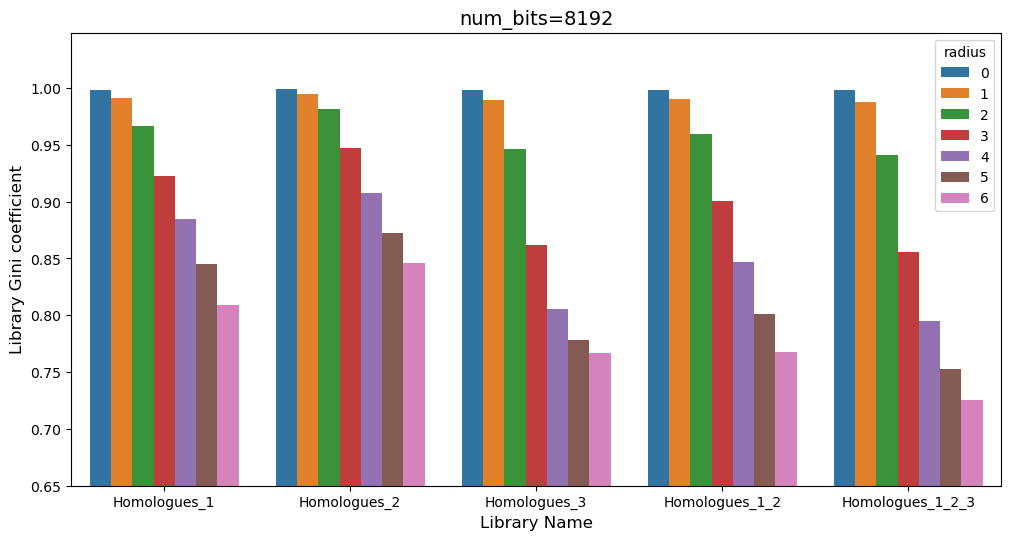

In [5]:
fig, ax = plt.subplots(dpi=100, figsize=(12,6))
g = sns.barplot(x="sdf", y="gini", data=df, hue="radius", ax=ax)
ax.set_xlabel("Library Name", fontsize=12)
ax.set_ylabel("Library Gini coefficient", fontsize=12)
ax.set_title("num_bits={num_bits}".format(num_bits=num_bits), fontsize=14)
ax.set_ylim(0.65, None)
plt.show()

## Random Compounds
Random compound smiles pulled from ZINC15 (ca 2020-12-03)
Note: for this, didn't bother to strip salts or standardize
      tautomeric forms or explicitly remove duplicates - just using as-is.
https://zinc15.docking.org/tranches/home/#
 - Selected 2D, drug-like, anodyne, and in-stock to winnow down number to randomly subselect from
 - 5,745,695 compounds across 180 tranches
 - Smiles not in git repo, must download them: *wget -i ZINC-downloader-2D-smi.uri* in random-compounds directory

In [7]:
# Parse and read-in random smiles
rnd_dir = "random-compounds/"
rnd_smiles = []
lof = [os.path.join(rnd_dir, f) for f in os.listdir(rnd_dir) if f.endswith(".smi")]
for f in lof:
    with open(f, "r") as file:
        # Split space, remove header
        dat = [x.strip().split() for x in file.readlines()][1:]
        [rnd_smiles.append(x) for x in dat]
smi = pd.DataFrame(data=rnd_smiles, columns=["smiles", "id"])
smi.head()

,smiles,id
0,Cn1c2ncn(C[C@@H](O)CN3C[C@H]4C[C@@H](C3)Cn3c(=...,ZINC000001321513
1,CCN(CC)S(=O)(=O)c1ccc(S(=O)(=O)N2CCN(S(C)(=O)=...,ZINC000001351167
2,CS(=O)(=O)N1CCN(S(=O)(=O)c2ccc(S(=O)(=O)N3CCCC...,ZINC000001357740
3,CCS(=O)(=O)N1CCN(S(=O)(=O)c2ccc(S(=O)(=O)NC3CC...,ZINC000001357822
4,Nc1nc(N)c2nc(CNc3ccc(C(=O)N[C@@H](CC(=O)O)C(=O...,ZINC000001643830


In [10]:
# To see how Gini coefficient of homologs vary as a function of radius
# versus the same number of randomly selected compounds whose G is computed
# using the same radii.  Is it proportional or some other non-linear relationship?
rdf = []
num_bits = 8192
for bm in sorted_names:
    # Num compounds for ref
    n_mols = len(benchmark_mols_dict[bm])
    print("Working on random with n={} mols".format(n_mols))
    resample = 10
    rnd_smiles = []
    # Select random smiles
    for i in range(resample):
        rnd_smiles.append(list(smi.sample(n=n_mols, replace=False, random_state=i)["smiles"]))
    # Calculate mean and stdev of random samples
    # for this given n_compounds and radius size
    for radius in radii:
        print(" - radius={}".format(radius))
        rnd_g = []
        for rnd in rnd_smiles:
            # Compute fingerprint vectors
            rnd_mols = [MolFromSmiles(s) for s in rnd]
            fpvec = parallel_binary_fingerprint(rnd_mols, num_bits=num_bits, radius=radius, drop_empty=True)
            # Calc gini
            g = fingerprint_gini(fpvec)  
            rnd_g.append(g)
        # Compute mean and stdev
        rnd_g = np.array(rnd_g)
        g_mu = rnd_g.mean()
        g_std = rnd_g.std()
        # Append to new dataframe
        rdf.append(["Z15rnd_{}".format(n_mols), num_bits, radius, g_mu, g_std, n_mols])
rdf = pd.DataFrame(data=rdf, columns=gini_df_cols)

Working on random with n=3000 mols
 - radius=0
 - radius=1
 - radius=2
 - radius=3
 - radius=4
 - radius=5
 - radius=6
Working on random with n=3629 mols
 - radius=0
 - radius=1
 - radius=2
 - radius=3
 - radius=4
 - radius=5
 - radius=6
Working on random with n=4638 mols
 - radius=0
 - radius=1
 - radius=2
 - radius=3
 - radius=4
 - radius=5
 - radius=6
Working on random with n=6629 mols
 - radius=0
 - radius=1
 - radius=2
 - radius=3
 - radius=4
 - radius=5
 - radius=6
Working on random with n=11267 mols
 - radius=0
 - radius=1
 - radius=2
 - radius=3
 - radius=4
 - radius=5
 - radius=6


In [18]:
rdf.head(7)

,sdf,num_bits,radius,gini,std,num_mols
0,Z15rnd_3000,8192,0,0.998126,0.000006,3000
1,Z15rnd_3000,8192,1,0.974133,0.000239,3000
2,Z15rnd_3000,8192,2,0.821269,0.000907,3000
3,Z15rnd_3000,8192,3,0.655873,0.000916,3000
4,Z15rnd_3000,8192,4,0.570425,0.001214,3000
5,Z15rnd_3000,8192,5,0.522328,0.001374,3000
6,Z15rnd_3000,8192,6,0.495613,0.001410,3000


In [16]:
# Because each benchmark sdf has a unique number of mols,
# can divide benchmark gini coeffs by random gini coeffs
# and propagate error to arrive at fold-change in gini
# coefficient of these benchmark libraries over random
# libraries with same radius and number of bits
mdf = pd.merge(df, rdf[["radius", "num_mols", "gini", "std"]], on=["num_mols", "radius"])
mdf["delta"] = mdf["gini_x"] / mdf["gini_y"]
# As stdev = 0 for homologs, no need to use that in propagation of error with division
# Error is quite small because variance in the 10 randomly sampled libraries is small
mdf["delta_err"] = np.sqrt((mdf["std_y"] / mdf["gini_y"])**2)
mdf.head()

,sdf,num_bits,radius,gini_x,std_x,num_mols,gini_y,std_y,delta,delta_err
0,Homologues_1,8192,0,0.998362,0,3000,0.998126,0.000006,1.000236,0.000006
1,Homologues_1,8192,1,0.990972,0,3000,0.974133,0.000239,1.017286,0.000245
2,Homologues_1,8192,2,0.966279,0,3000,0.821269,0.000907,1.176568,0.001104
3,Homologues_1,8192,3,0.922908,0,3000,0.655873,0.000916,1.407144,0.001396
4,Homologues_1,8192,4,0.885157,0,3000,0.570425,0.001214,1.551749,0.002129


## Speculation
Larger radius in fingerprint calculation seems to result in broader dispersion among the individual and combined homolog sets that is not seen in the matched, randomly sampled compound sets.  Larger radius in ECFP/MFP generation may give rise to greater discriminating power in calculated Gini coefficient, especially in less diverse libraries - of course depending on content of chemical library.  For these calculations the effect seems to taper off around a radius of 6.

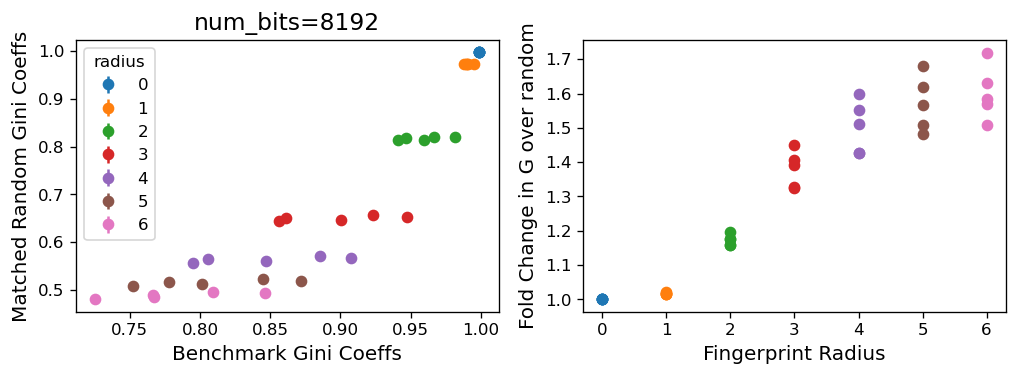

In [12]:
# Standard deviation on the random
fig, ax = plt.subplots(dpi=120, ncols=2, figsize=(10,3))
for radius in radii:
    tdf = mdf[mdf["radius"] == radius]
    ax[0].errorbar(tdf["gini_x"], tdf["gini_y"], yerr=tdf["std_y"], fmt="o", label=radius)
    ax[1].errorbar(tdf["radius"], tdf["delta"], yerr=tdf["delta_err"], fmt="o", label=radius)
ax[0].set_xlabel("Benchmark Gini Coeffs", fontsize=12)
ax[0].set_ylabel("Matched Random Gini Coeffs", fontsize=12)
ax[1].set_xlabel("Fingerprint Radius", fontsize=12)
ax[1].set_ylabel("Fold Change in G over random", fontsize=12)
ax[0].legend(title="radius")
ax[0].set_title("num_bits={num_bits}".format(num_bits=num_bits), fontsize=14)
plt.show()

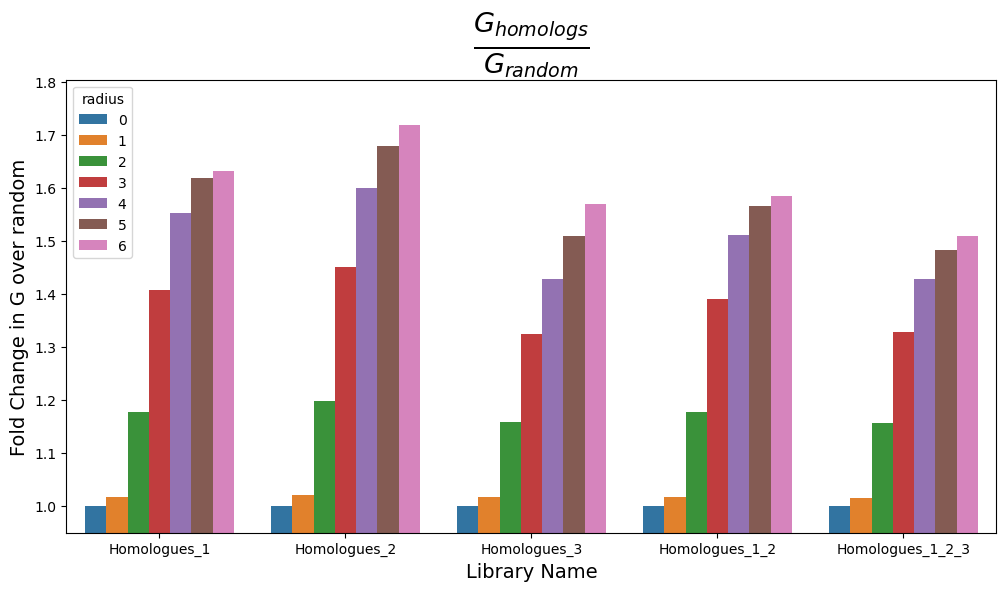

In [14]:
fig, ax = plt.subplots(dpi=100, figsize=(12,6))
g = sns.barplot(x="sdf", y="delta", data=mdf, hue="radius", ax=ax)
ax.set_xlabel("Library Name", fontsize=14)
ax.set_ylabel("Fold Change in G over random", fontsize=14)
ax.set_title(r"$\frac{G_{homologs}}{G_{random}}$", fontsize=28)
ax.set_ylim(0.95, None)
plt.show()